In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Modified for NR segmentation and measurement

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/htao7/sam_nr/blob/main/demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [3]:
using_colab = True

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib pandas
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !wget -c https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
    !wget -c https://github.com/htao7/sam_nr/raw/main/nr.jpg

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-rwo387ip
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-rwo387ip
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
--2025-06-14 15:35:21--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.90, 13.35.37.111, 13.35.37.84, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.90|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2025-06-14 15:35:22--  https://github.com/htao7/sam_nr/raw/main/nr.jpg
Resolving github

## Set-up

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

## Example image

In [6]:
image = cv2.imread('nr.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

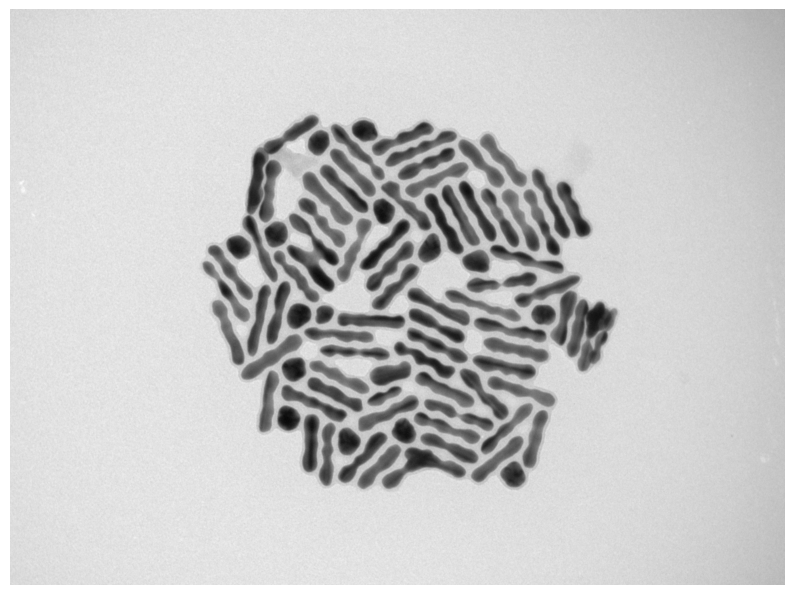

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [17]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.96,
    stability_score_offset = 1.5,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

To generate masks, just run `generate` on an image.

In [18]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [19]:
print(len(masks))
print(masks[0].keys())

100
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [20]:
# prompt: a function 'find_min_bbox' to find the Rotated Minimum Bounding Box for each mask in masks

import numpy as np
def find_min_bbox(masks):
    """
    Finds the Rotated Minimum Bounding Box for each mask in a list of masks.

    Args:
        masks (list): A list of dictionaries, where each dictionary contains
                      a 'segmentation' key with a binary mask (numpy array).

    Returns:
        list: A list of tuples, where each tuple represents the Rotated Minimum Bounding Box
              for a mask in the format ((center_x, center_y), (width, height), angle).
              Returns an empty list if no masks are provided or if a mask is empty.
    """
    bboxes = []
    for mask_info in masks:
        segmentation = mask_info['segmentation']
        # Ensure the mask is a numpy array and is binary
        if not isinstance(segmentation, np.ndarray) or segmentation.dtype != np.bool_:
            print("Warning: Skipping mask as 'segmentation' is not a boolean numpy array.")
            continue

        # Convert the boolean mask to uint8 for findContours
        segmentation_uint8 = segmentation.astype(np.uint8)

        # Find contours
        # Use RETR_EXTERNAL to get only the outer contours
        # Use CHAIN_APPROX_SIMPLE to compress horizontal, vertical, and diagonal segments
        contours, _ = cv2.findContours(segmentation_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Find the largest contour by area if there are multiple
            largest_contour = max(contours, key=cv2.contourArea)

            # Get the rotated bounding box for the largest contour
            # The result is a Box2D structure which contains:
            #   (center_x, center_y), (width, height), angle of rotation (in degrees)
            min_bbox = cv2.minAreaRect(largest_contour)
            bboxes.append(min_bbox)
        else:
            # Handle cases where no contours are found (e.g., entirely zero mask)
            print("Warning: No contours found for a mask.")
            # Append a placeholder or None, depending on desired behavior
            # bboxes.append(None) # Or some other indicator

    return bboxes

# Example usage (assuming 'masks' is already generated from previous code):
rotated_bboxes = find_min_bbox(masks)

In [21]:
# prompt: a function 'filter_rods' to take in each mask in masks and the image, and decide if (1) 90% pixels in mask in the iamge is black (assuming the black in the image is value < 150), (2) the pixels in mask forms a elongated shape, if both,  add the index of the mask into roi_list and return roi_list

import numpy as np
import cv2 # Make sure cv2 is imported
def filter_rods(masks, rotated_bboxes, image):
    roi_list = []
    # Convert image to grayscale for thresholding
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    for i, mask_data in enumerate(masks):
        mask = mask_data['segmentation']
        # (1) Check if 90% pixels in mask in the image is black
        # Use the grayscale image for thresholding
        masked_image = gray_image[mask]
        black_thr, _ = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Apply threshold on grayscale
        black_pixels = np.sum(masked_image < black_thr)
        total_pixels = np.sum(mask)
        if total_pixels > 0 and (black_pixels / total_pixels) >= 0.9:
          # (2) Check if the pixels in mask forms an elongated shape
          # Ensure we don't go out of bounds for rotated_bboxes
            ((center_x, center_y), (width, height), angle) = rotated_bboxes[i]
            # 1. Check aspect ratio
            if width > 0 and height > 0:
                aspect_ratio = max(width, height) / min(width, height)
                if aspect_ratio > 3:
                    roi_list.append(i)
    return roi_list

roi_list = filter_rods(masks, rotated_bboxes, image)

In [22]:
masks_rods = [mask for i, mask in enumerate(masks) if i in roi_list]
bboxs_rods = [bbox for i, bbox in enumerate(rotated_bboxes) if i in roi_list]

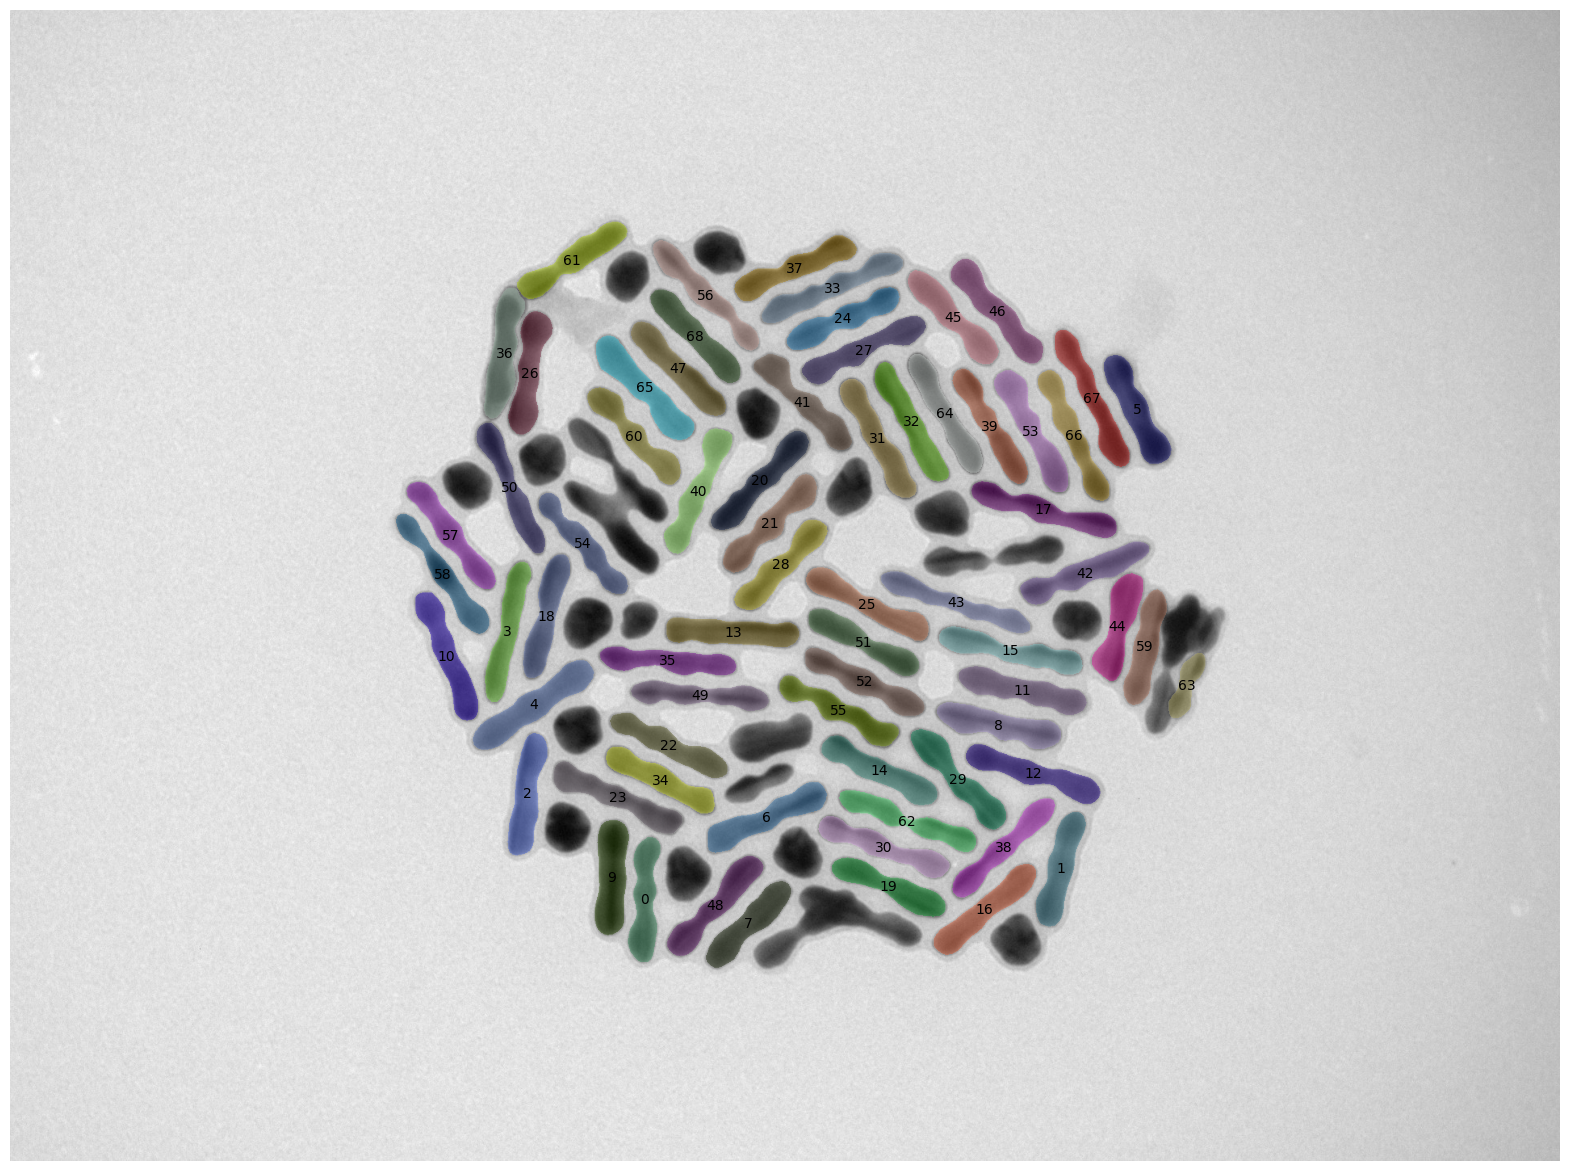

In [23]:
def show_anns(anns, bboxs):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for i, ann in enumerate(anns):
        area = ann['area']
        m = ann['segmentation']
        pos = ann['bbox']
        color_mask = np.concatenate([np.random.random(3), [0.4]])
        img[m] = color_mask
        # Get the four corners of the rotated rectangle
        # rect = (bboxs[i][0], bboxs[i][1], bboxs[i][2])
        # box = cv2.boxPoints(rect)
        # box = np.intp(box) # Convert to integer coordinates
        # cv2.drawContours(img, [box], 0, (0, 1, 0, 1), 2)
        ax.text(int(pos[0] + pos[2] / 2), int(pos[1] + pos[3] / 2), s=i, ha='center', va='center')
    ax.imshow(img)

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks_rods, bboxs_rods)
plt.axis('off')
plt.show()

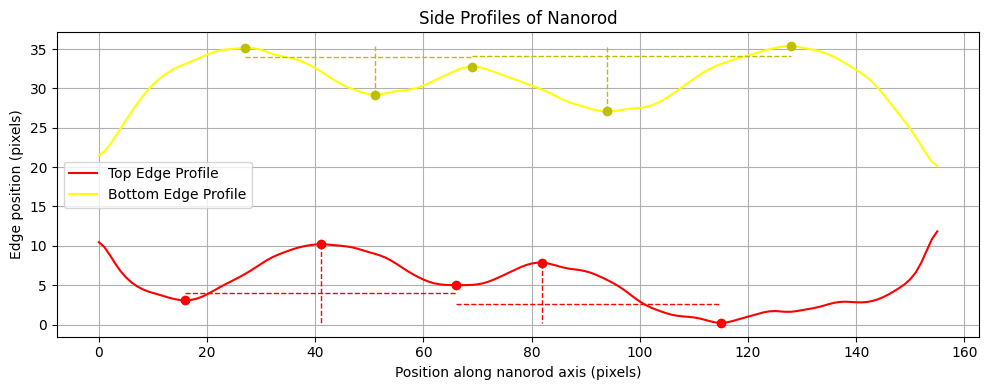

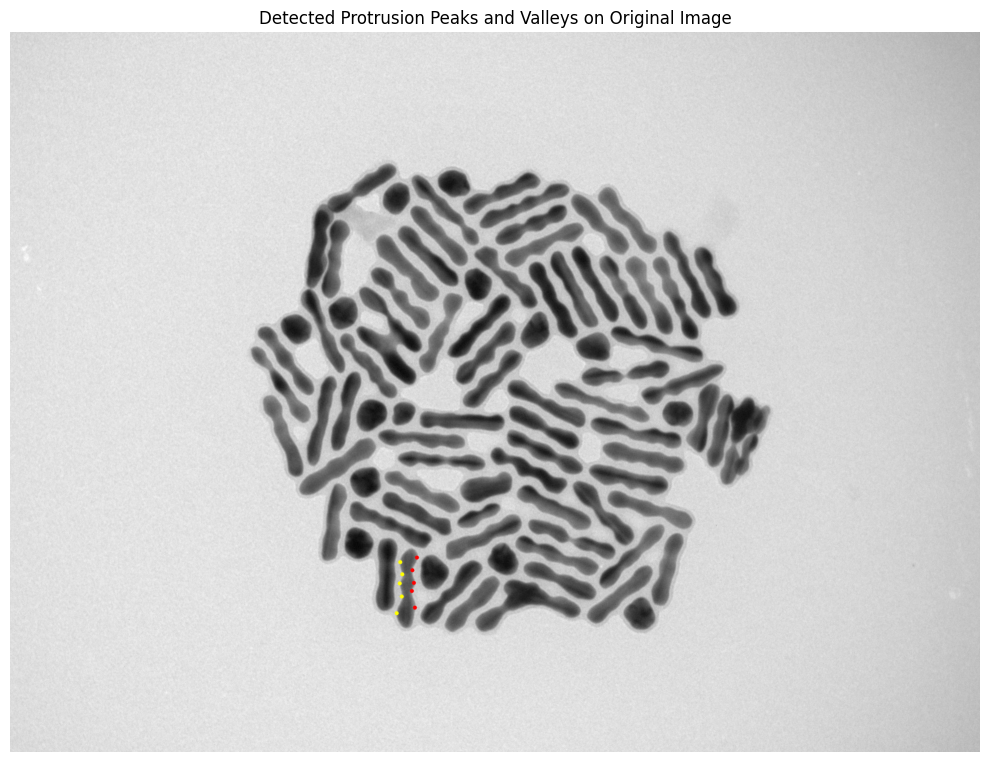

(154.7449493408203,
 35.4166259765625,
 array([50, 49, 42, 59]),
 array([9.99014273, 7.65123205, 6.16973772, 8.30019721]),
 4)

In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

def extract_side_profiles(image, mask, bbox, smooth_sigma=2, plot=True):
    """
    Extracts and plots both side profiles of a nanorod.

    Parameters:
        image: Original image.
        mask: 2D binary mask (only for one nanorod).
        bbox: Rotated bounding box ((cx, cy), (w, h), angle).
        smooth_sigma: Gaussian smoothing parameter.
        plot: Whether to plot both side profiles.
    """
    (cx, cy), (w, h), angle = bbox
    if w < h:
        angle += 90  # ensure long side is horizontal

    # Rotate mask
    rot_mat = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    rotated = cv2.warpAffine(mask.astype(np.uint8), rot_mat, (mask.shape[1], mask.shape[0]))

    # Crop to bounding box region
    # box = cv2.boxPoints(((cx, cy), (w, h), angle))
    # box = np.intp(cv2.transform(np.array([box]), rot_mat)[0])
    # x, y, w_crop, h_crop = cv2.boundingRect(box)
    # cropped = rotated[y:y+h_crop, x:x+w_crop]

    # alternative: Find bounding box of non-zero region in rotated mask (actual rod area)
    ys, xs = np.where(rotated > 0)
    x_min, x_max = np.min(xs), np.max(xs)
    y_min, y_max = np.min(ys), np.max(ys)
    cropped = rotated[y_min:y_max+1, x_min:x_max+1]

    # Extract side profiles (top and bottom for each x column)
    cols = cropped.shape[1]
    top_profile = []
    bottom_profile = []

    for i in range(cols):
        col = cropped[:, i]
        ys = np.where(col > 0)[0]
        if len(ys) > 0:
            top_profile.append(ys[0])
            bottom_profile.append(ys[-1])
        else:
            top_profile.append(np.nan)
            bottom_profile.append(np.nan)

    top_profile = np.array(top_profile)
    bottom_profile = np.array(bottom_profile)

    # Interpolate missing values (optional)
    def fill_nan(profile):
        valid = ~np.isnan(profile)
        return np.interp(np.arange(len(profile)), np.flatnonzero(valid), profile[valid])

    top_profile_filled = fill_nan(top_profile)
    bottom_profile_filled = fill_nan(bottom_profile)

    # Smooth profiles
    top_smooth = gaussian_filter1d(top_profile_filled, sigma=smooth_sigma)
    bottom_smooth = gaussian_filter1d(bottom_profile_filled, sigma=smooth_sigma)

    # Detect protrusions (peaks and valleys)
    top_peaks, _ = find_peaks(-top_smooth, distance=10, prominence=0.5)
    top_valleys, _ = find_peaks(top_smooth, distance=10, prominence=0.5)
    bottom_peaks, _ = find_peaks(bottom_smooth, distance=10, prominence=0.5)
    bottom_valleys, _ = find_peaks(-bottom_smooth, distance=10, prominence=0.5)

    # Compute spacings
    spacing_top = np.diff(top_peaks)
    spacing_bottom = np.diff(bottom_peaks)
    spacing = np.concatenate([spacing_top, spacing_bottom])

    # Depth: distance from valleys to their corresponding edge (top or bottom)
    depth_top = top_smooth[top_valleys] - np.min(top_smooth)
    depth_bottom = np.max(bottom_smooth) - bottom_smooth[bottom_valleys]
    depth = np.concatenate([depth_top, depth_bottom])

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(top_smooth, label='Top Edge Profile', color='red')
        plt.plot(bottom_smooth, label='Bottom Edge Profile', color='yellow')
        plt.plot(top_peaks, top_smooth[top_peaks], 'ro')
        plt.plot(bottom_peaks, bottom_smooth[bottom_peaks], 'yo')
        plt.plot(top_valleys, top_smooth[top_valleys], 'ro')
        plt.plot(bottom_valleys, bottom_smooth[bottom_valleys], 'yo')
        # Plot spacing lines (vertical dashed lines between adjacent peaks)
        for i in range(len(top_peaks) - 1):
            x1, x2 = top_peaks[i], top_peaks[i+1]
            y_avg = (top_smooth[x1] + top_smooth[x2]) / 2
            plt.plot([x1, x2], [y_avg, y_avg], 'r--', linewidth=1)

        for i in range(len(bottom_peaks) - 1):
            x1, x2 = bottom_peaks[i], bottom_peaks[i+1]
            y_avg = (bottom_smooth[x1] + bottom_smooth[x2]) / 2
            plt.plot([x1, x2], [y_avg, y_avg], 'y--', linewidth=1)

        # Plot depth lines (vertical dashed lines from valley to edge)
        for x, y in zip(top_valleys, top_smooth[top_valleys]):
            plt.plot([x, x], [y, np.min(top_smooth)], 'r--', linewidth=1)

        for x, y in zip(bottom_valleys, bottom_smooth[bottom_valleys]):
            plt.plot([x, x], [y, np.max(bottom_smooth)], 'y--', linewidth=1)
        plt.legend()
        plt.title("Side Profiles of Nanorod")
        plt.xlabel("Position along nanorod axis (pixels)")
        plt.ylabel("Edge position (pixels)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        overlay_img = image.copy()
        if len(overlay_img.shape) == 2:
            overlay_img = cv2.cvtColor(overlay_img, cv2.COLOR_GRAY2RGB)

        # Re-map peak coordinates to original image space
        def map_back(xs, ys):
            # from cropped + rotated → original
            xs_full = xs + x_min
            ys_full = ys + y_min
            pts = np.vstack([xs_full, ys_full, np.ones_like(xs_full)]).T
            inv_mat = cv2.invertAffineTransform(rot_mat)
            mapped = pts @ inv_mat.T
            return mapped[:, 0], mapped[:, 1]

        # Draw peaks
        tp_x, tp_y = map_back(np.array(top_peaks), top_smooth[top_peaks])
        bp_x, bp_y = map_back(np.array(bottom_peaks), bottom_smooth[bottom_peaks])
        for x, y in zip(tp_x, tp_y):
            cv2.circle(overlay_img, (int(x), int(y)), 4, (255, 0, 0), -1)
        for x, y in zip(bp_x, bp_y):
            cv2.circle(overlay_img, (int(x), int(y)), 4, (255, 255, 0), -1)

        # Draw valleys
        tv_x, tv_y = map_back(np.array(top_valleys), top_smooth[top_valleys])
        bv_x, bv_y = map_back(np.array(bottom_valleys), bottom_smooth[bottom_valleys])

        for x, y in zip(tv_x, tv_y):
            cv2.circle(overlay_img, (int(x), int(y)), 4, (255, 0, 0), -1)

        for x, y in zip(bv_x, bv_y):
            cv2.circle(overlay_img, (int(x), int(y)), 4, (255, 255, 0), -1)

        plt.figure(figsize=(10, 10))
        plt.imshow(overlay_img)
        plt.title("Detected Protrusion Peaks and Valleys on Original Image")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return max(w, h), min(w, h), spacing, depth, len(spacing)

extract_side_profiles(image, masks_rods[0]['segmentation'], bboxs_rods[0], plot=True)

In [26]:
# prompt: iterate through all masks_rods and bboxs_rods to go into extract_side_profiles, get the spacing and concatenate all the returned spacing together

import numpy as np
import pandas as pd

measurements = pd.DataFrame(columns=['#', 'rod_w', 'rod_h', 'dip_cnt', 'dip_sp_avg', 'dip_sp_std', 'dip_de_avg', 'dip_de_std'])

for i, (mask_rod, bbox_rod) in enumerate(zip(masks_rods, bboxs_rods)):
    # Extract the segmentation mask from the mask dictionary
    segmentation_mask = mask_rod['segmentation']

    # Call extract_side_profiles for each pair of mask and bbox
    # Set plot=False to avoid plotting each profile within the loop
    w, h, spacing, depth, cnt = extract_side_profiles(image, segmentation_mask, bbox_rod, plot=False)

    # Concatenate the returned spacing and depth (which is a numpy array)
    measurements.loc[i] = [i, w, h, cnt, np.mean(spacing), np.std(spacing), np.mean(depth), np.std(depth)]

print(f"Total number of detected rods: {len(measurements)}")
print(f"\nAverage number of spacings per rod: {measurements['dip_cnt'].mean():.2f}")
print(f"Standard deviation of number of spacings per rod: {measurements['dip_cnt'].std():.2f}")

N = measurements['dip_cnt'].sum()
# Overall average
overall_sp_avg = (measurements['dip_cnt'] * measurements['dip_sp_avg']).sum() / N
overall_de_avg = (measurements['dip_cnt'] * measurements['dip_de_avg']).sum() / N
# Overall variance
overall_sp_var = ((measurements['dip_cnt'] * (measurements['dip_sp_std'] ** 2 + (measurements['dip_sp_avg'] - overall_sp_avg) ** 2)).sum()) / N
overall_de_var = ((measurements['dip_cnt'] * (measurements['dip_de_std'] ** 2 + (measurements['dip_de_avg'] - overall_de_avg) ** 2)).sum()) / N
# Overall standard deviation
overall_sp_std = np.sqrt(overall_sp_var)
overall_de_std = np.sqrt(overall_de_var)

print(f"\nAverage of spacing: {overall_sp_avg:.2f}, STD of spacing: {overall_sp_std:.2f}")
print(f"Average of depth: {overall_de_avg:.2f}, STD of depth: {overall_de_std:.2f}\n")
print(measurements)

Total number of detected rods: 69

Average number of spacings per rod: 4.03
Standard deviation of number of spacings per rod: 0.89

Average of spacing: 55.38, STD of spacing: 18.17
Average of depth: 5.96, STD of depth: 3.00

       #       rod_w      rod_h  dip_cnt  dip_sp_avg  dip_sp_std  dip_de_avg  \
0    0.0  154.744949  35.416626      4.0   50.000000    6.041523    8.027827   
1    1.0  146.285248  35.995556      4.0   48.250000    7.949057    4.143165   
2    2.0  153.211288  34.323437      3.0   57.666667   18.517259    4.209451   
3    3.0  177.787674  28.618145      4.0   63.500000   33.094561    3.285942   
4    4.0  174.730560  38.274315      4.0   60.000000    7.516648    4.960777   
..   ...         ...        ...      ...         ...         ...         ...   
64  64.0  165.216492  31.675880      4.0   46.750000   13.754545    5.188168   
65  65.0  164.201019  39.823208      4.0   60.250000   21.288201    7.015179   
66  66.0  175.780457  30.983244      5.0   55.200000   